# Introduction

- Predictive maintenance on NASA's turbofan engine degradation dataset (CMAPSS). 
- There are 4 datasets available of increasing complexity.Data Set FD001 is the first in the series and the least complex. All datasets can be accessed via link https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan
- In this article an attempt has been made to perform to predict RUL( Remaining Useful Life of Engine) by applying various ML Model on FD001 dataset.
Data Set FD001 is the first in the series and the least complex.  
Train trjectories: 100 engines.
Test trajectories: 100  engines.
Fault Modes: ONE

- Datasets include simulations of multiple turbofan engines over time, each row contains the following information:
  1. Engine unit number
  2. Time, in cycles
  3. Three operational settings
  4. 21 sensor readings.




# Importing Necessary Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", None)


# Importing the Dataset

In [2]:

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('train_FD001.txt',sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt',sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# Train data contains all features (Unit Number + setting parameters & sensor parameters)
# Test data contains all features (Unit Number + setting parameters & sensor parameters)
# Y_test contains RUL for the test data.
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
train['unit_nr'].unique()

# There are 100 no unique engines.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Note:  for Test Dataset Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
therefore the test dataset will be subsetted to represent the same.

In [4]:
test.shape

(13096, 26)

In [5]:
# Since the true RUL values (y_test) for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
test = test.groupby('unit_nr').last().reset_index().drop(['unit_nr','time_cycles'], axis=1)

In [6]:
y_test.shape

# RUL value for 100 no of engines.

(100, 1)

In [7]:
test.shape
# Now test data contains entries for 100 no of engines with their RUL.

(100, 24)

# Data Pre-Processing + Data Visualization

In [8]:
train.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [9]:
# Remove setting_3 column as we can see that it's value is not changing theerfore will not not add any information to our 
# prediction
train=train.drop('setting_3',axis=1)

In [10]:
# Adding RUL (Ramining Useful Life) to the train dataset

In [11]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[sensor_names+['RUL']].head()

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [12]:
train.head(5)

,unit_nr,time_cycles,setting_1,setting_2,s_1,s_2,s_3,s_4,s_5,s_6,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,518.67,641.82,1589.70,1400.60,14.62,21.61,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,518.67,642.15,1591.82,1403.14,14.62,21.61,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,518.67,642.35,1587.99,1404.20,14.62,21.61,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,518.67,642.35,1582.79,1401.87,14.62,21.61,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,518.67,642.37,1582.85,1406.22,14.62,21.61,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


## Plotting of RUL

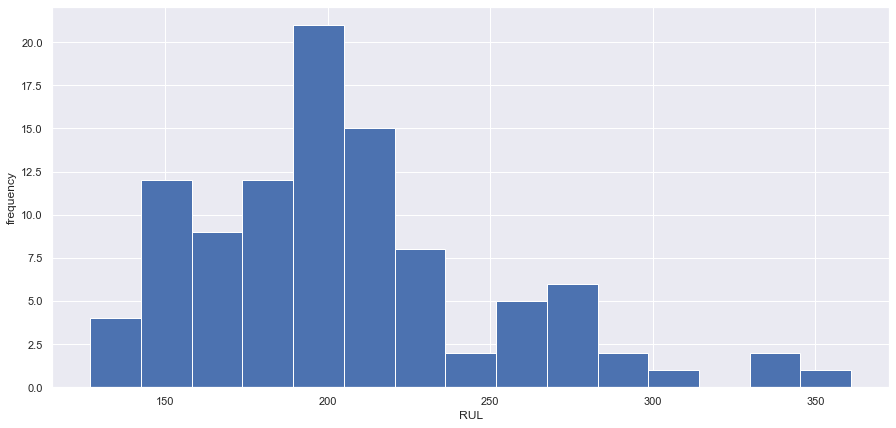

In [13]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [14]:
# We can see the RUL for engine is bit skewed on left side. This may affect perfomance of the model however as on 
# now we will keep it as it.


## Plotting of Sensor Values Vs RUL

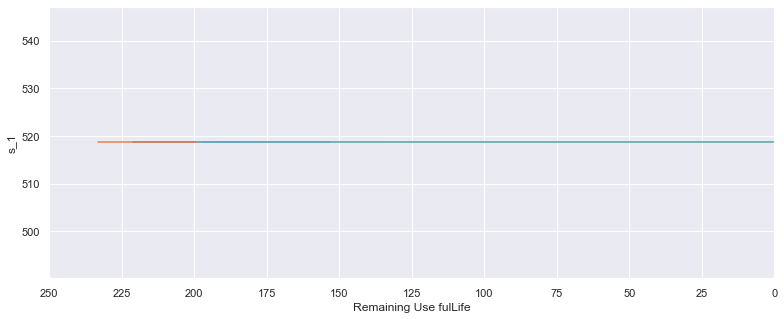

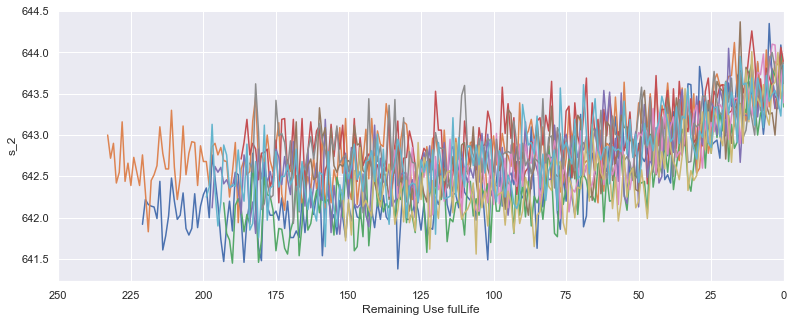

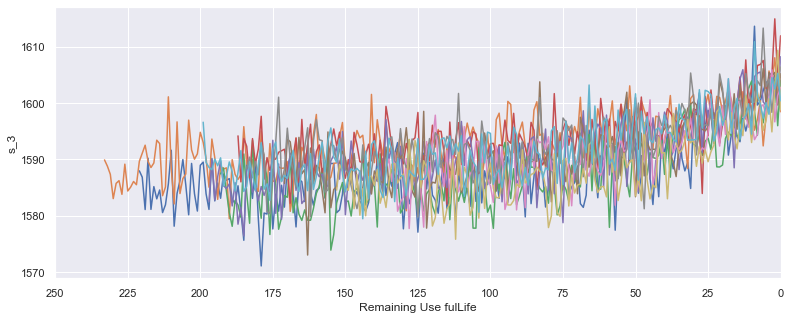

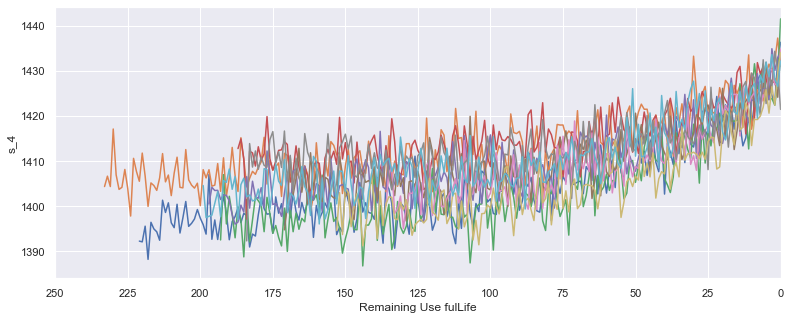

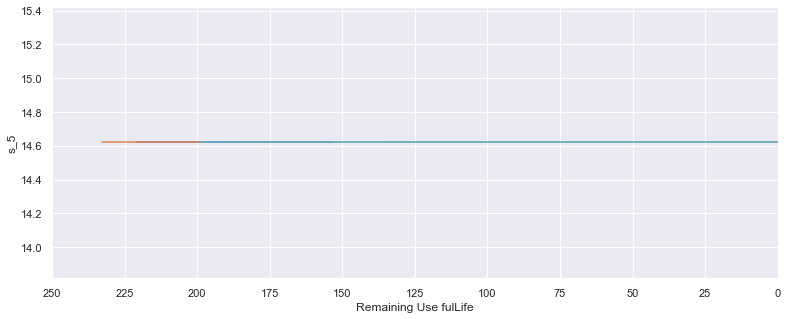

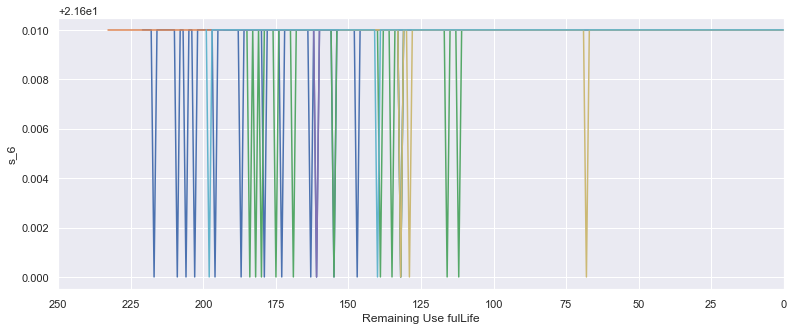

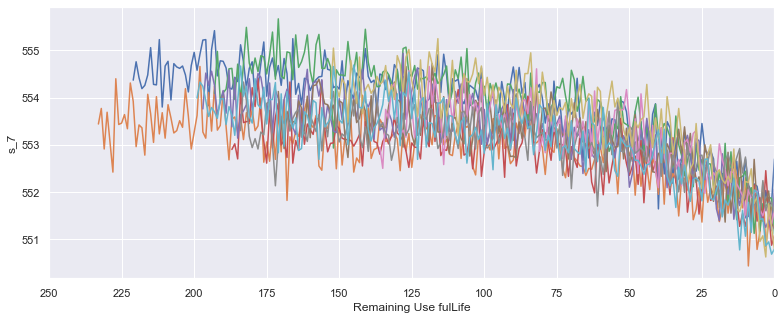

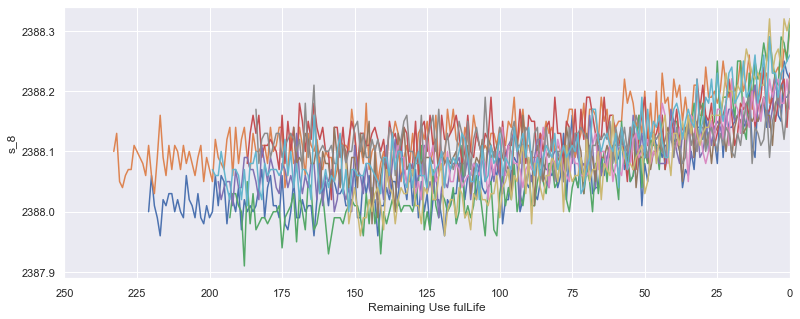

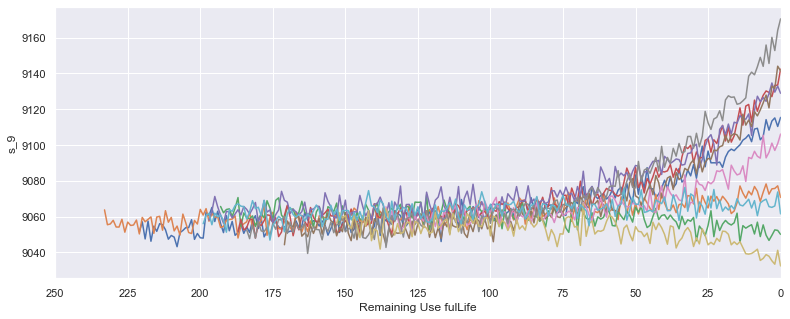

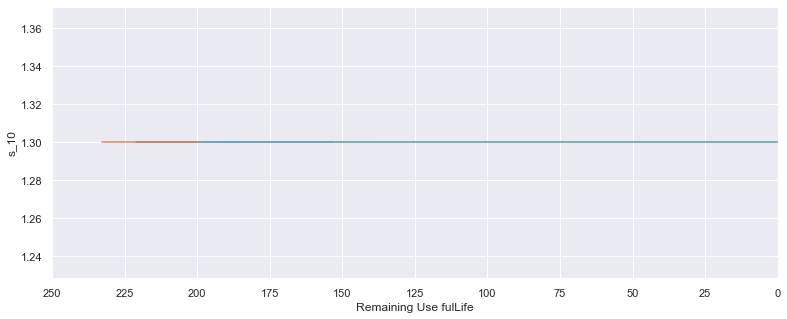

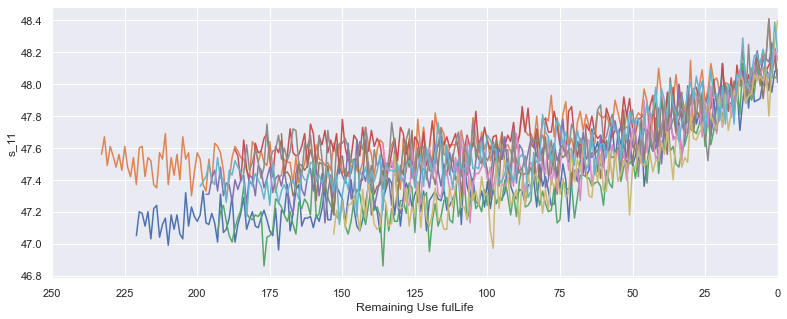

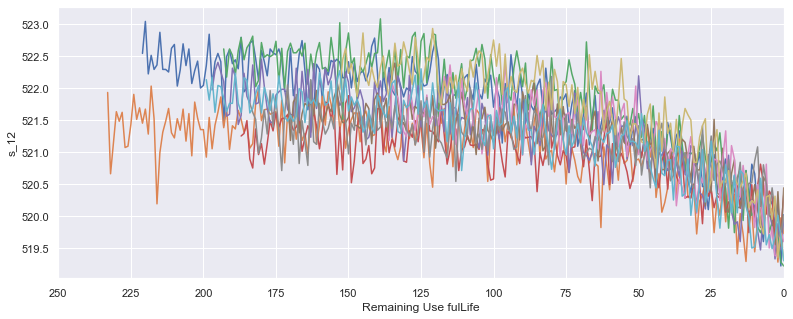

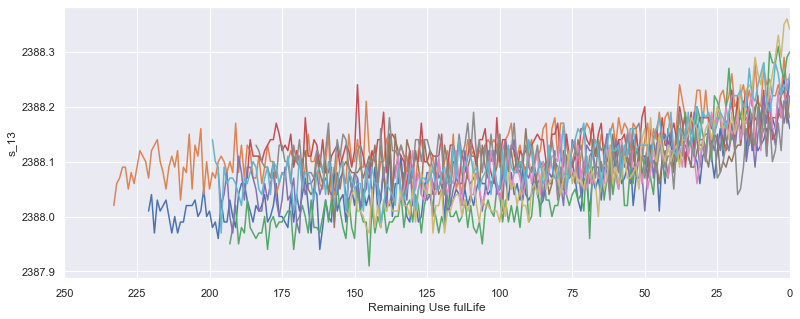

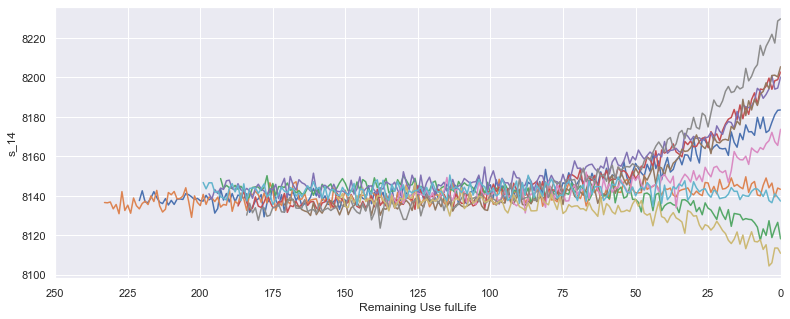

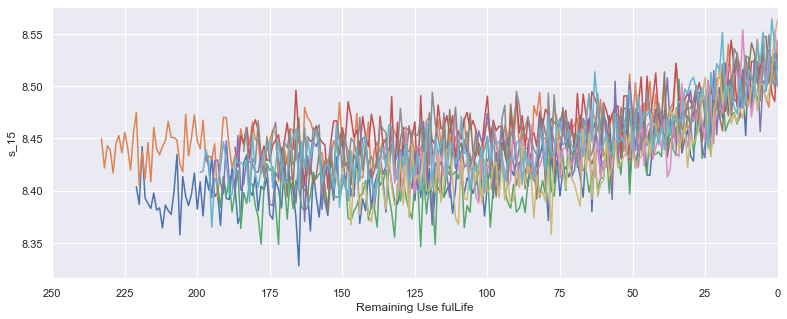

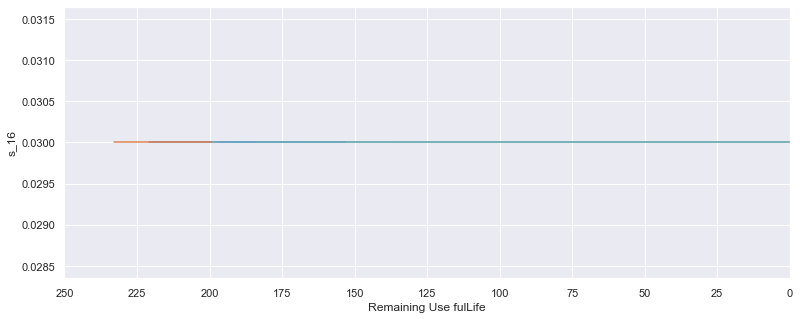

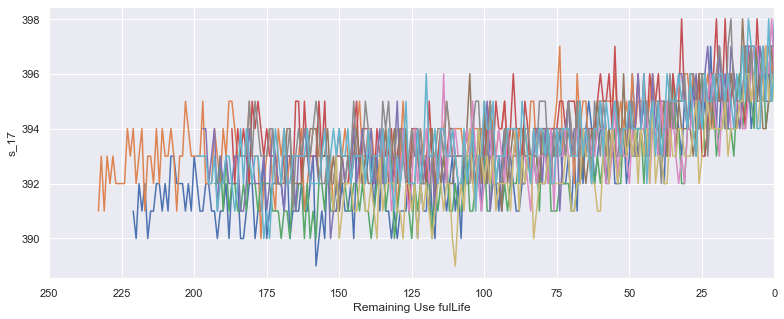

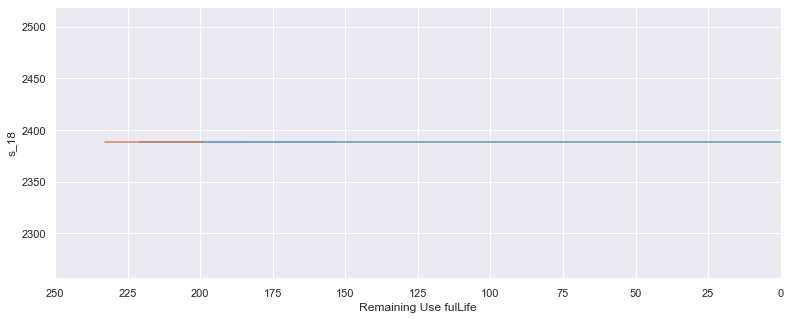

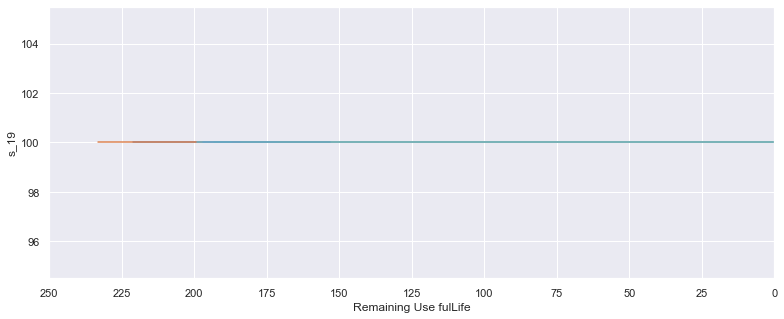

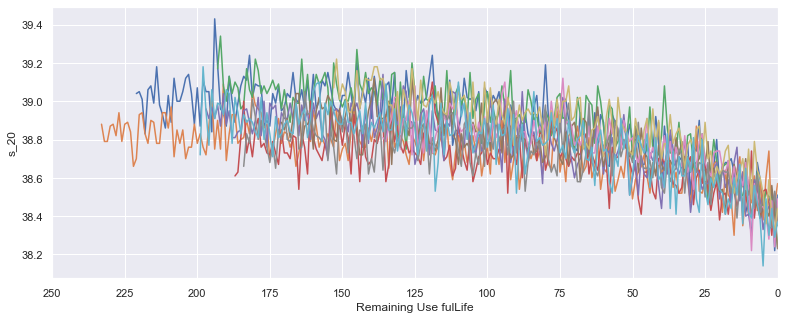

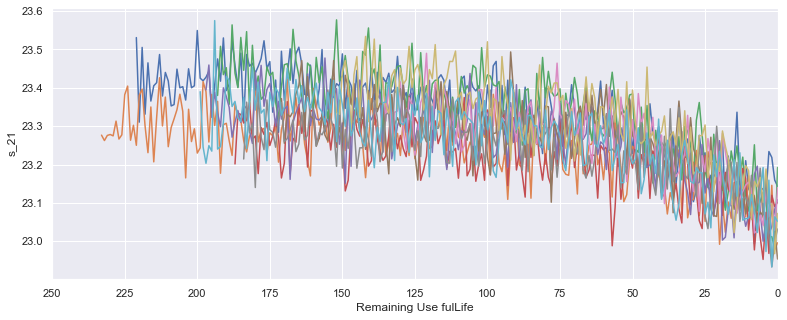

In [15]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

- Based on the plots you can see sensors 1, 5, 6, 10, 16, 18 and 19 hold no information related to Remaining Useful Life as the sensor values remain constant throughout time.
- As on now we will keep all features and will remove non-important features after calculating correlation value of each sensor variable with the RUL.

## Extraction of only Important Features which have strong relation affecting RUL of engine

In [16]:
# This is done to select only important features for model building in order to avoid problem of " Overfitting".

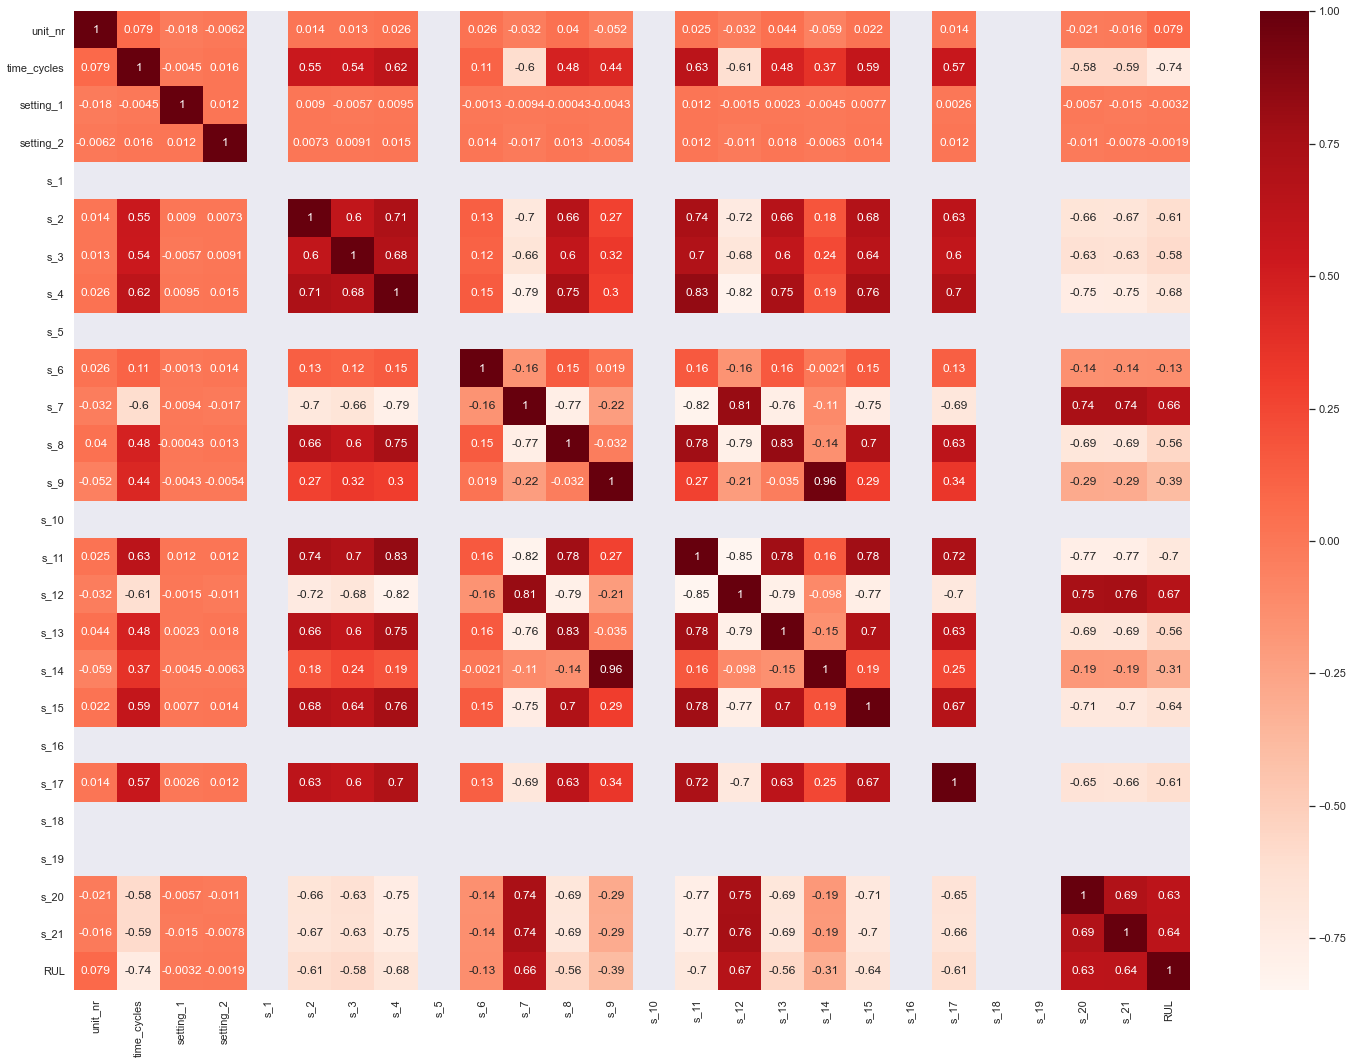

In [17]:
plt.figure(figsize=(25,18))
sns.heatmap(train.corr(),annot=True ,cmap='Reds')
plt.show()

In [18]:
cor=train.corr()
#cor_target = abs(cor["RUL"])
#Selecting highly correlated features
train_relevant_features = cor[abs(cor['RUL'])>=0.5]

train_relevant_features['RUL']

time_cycles   -0.736241
s_2           -0.606484
s_3           -0.584520
s_4           -0.678948
s_7            0.657223
s_8           -0.563968
s_11          -0.696228
s_12           0.671983
s_13          -0.562569
s_15          -0.642667
s_17          -0.606154
s_20           0.629428
s_21           0.635662
RUL            1.000000
Name: RUL, dtype: float64

In [19]:
list_relevant_features=train_relevant_features.index
list_relevant_features=list_relevant_features[1:]
list_relevant_features

Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_11', 's_12', 's_13', 's_15',
       's_17', 's_20', 's_21', 'RUL'],
      dtype='object')

In [20]:
# Above list contains important features have correlation of magnitude greater and equal to 0.5 with our target variable RUL.

In [21]:
# Now we will keep onlt these imprtant features in both train & test dataset.
train=train[list_relevant_features]

In [22]:
train.head(5)

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21,RUL
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


## Seperating Train & Test Data

In [23]:
# train & y_train
# Calculated RUL variable is our Target variable.
y_train=train['RUL']
X_train=train.drop(['RUL'],axis=1)
X_train.head(5)

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044


In [24]:
test.head(5)

,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


In [25]:
# Test data set , keeping only train columns/features.
X_test=test[X_train.columns]
X_test.head(5)

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21
0,642.58,1581.22,1398.91,554.42,2388.08,47.23,521.79,2388.06,8.4024,393,38.81,23.3552
1,642.55,1586.59,1410.83,553.52,2388.10,47.67,521.74,2388.09,8.4505,391,38.81,23.2618
2,642.88,1589.75,1418.89,552.59,2388.16,47.88,520.83,2388.14,8.4119,395,38.93,23.2740
3,642.78,1594.53,1406.88,552.64,2388.13,47.65,521.88,2388.11,8.4634,395,38.58,23.2581
4,642.27,1589.94,1419.36,553.29,2388.10,47.46,521.00,2388.15,8.4362,394,38.75,23.4117


In [26]:
y_test.head(5)

,RUL
0,112
1,98
2,69
3,82
4,91


In [27]:
# Clipping of RUL at 125 as after 125 , RUL is responding to the sensor values after this value.
# This is done to improve performance of the applied models.

y_train= y_train.clip(upper=125)

## Building Model

In [28]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse,variance;

### Model 1: Linear Regression

In [29]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train)
X_test1 = sc.transform(X_test)

In [30]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train1, y_train)

# predict and evaluate
y_hat_train1 = lm.predict(X_train1)
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1,'train')

y_hat_test1 = lm.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1,'test')

train set RMSE:22.734164950962253, R2:0.7023848970100307
test set RMSE:22.91426532858464, R2:0.695944872995172


In [31]:
# Make Dataframe which will contain results of all applied Model
Results=pd.DataFrame({'Model':['LR'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]})
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,22.734165,0.702385,22.914265,0.695945


Text(0.5, 1.0, 'Actual RUL Vs Predicted RUL for Train Data')

<Figure size 432x288 with 0 Axes>

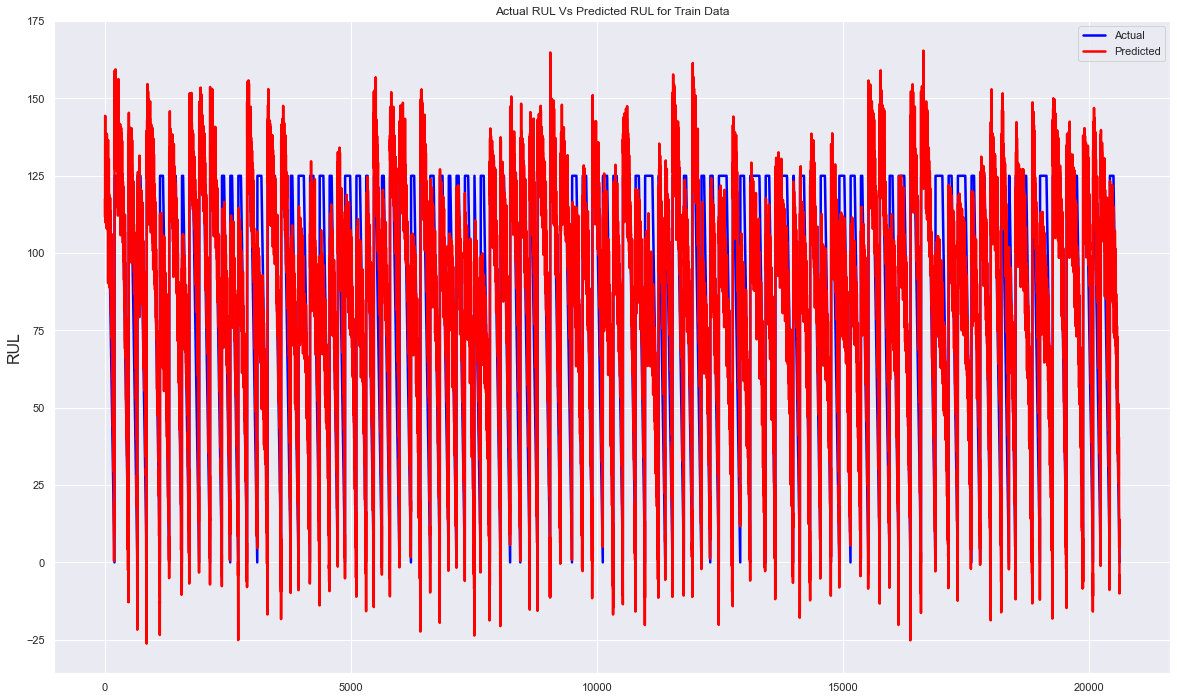

In [32]:
# Plot Actual Vs Predicted RUL for Train Data
#c = [i for i in range(1,81,1)]
fig = plt.figure();
plt.figure(figsize=[20,12])
plt.plot(y_train,color="blue", linewidth=2.5, linestyle="-",label="Actual")
plt.plot(y_hat_train1,color="red",  linewidth=2.5, linestyle="-",label="Predicted")
fig.suptitle('Actual and Predicted', fontsize=20)            # Plot heading 
#plt.xlabel('Index', fontsize=18)                            # X-label
plt.ylabel('RUL', fontsize=16)                               # Y-label
plt.legend()
plt.title("Actual RUL Vs Predicted RUL for Train Data")


In [33]:
# Making predictions using test set
y_hat_test1 = lm.predict(X_test1)
evaluate(y_test, y_hat_test1)

test set RMSE:22.91426532858464, R2:0.695944872995172


(22.91426532858464, 0.695944872995172)

Text(0.5, 1.0, 'Actual RUL Vs Predicted RUL for Test Data')

<Figure size 432x288 with 0 Axes>

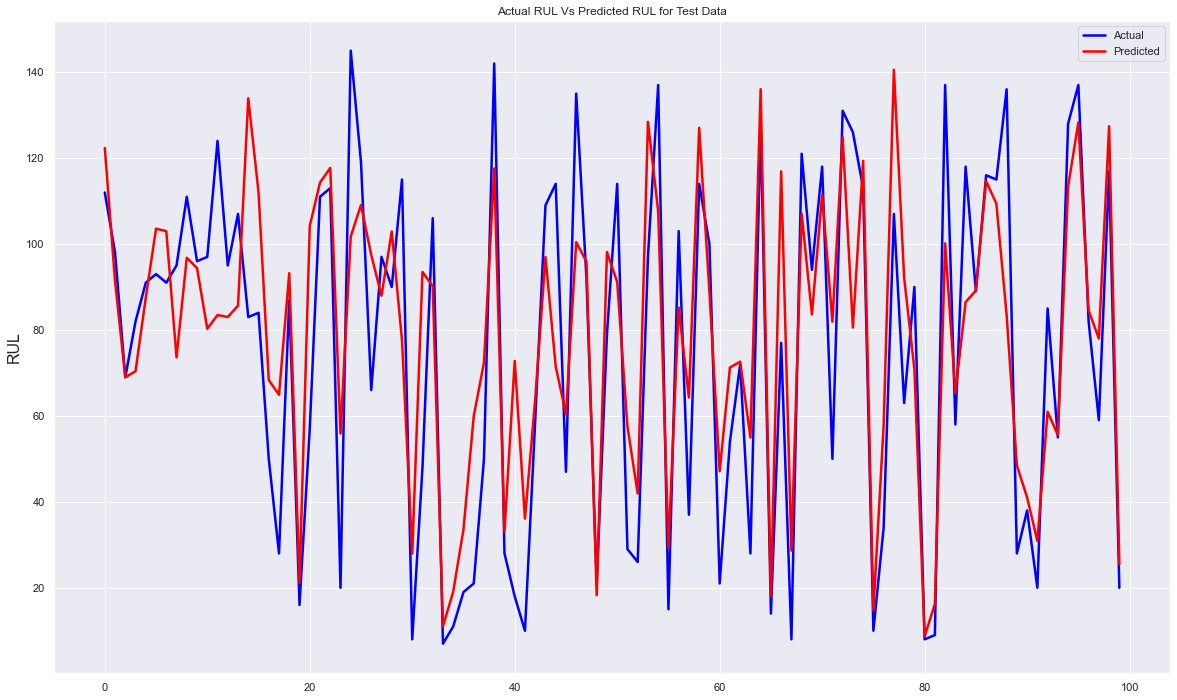

In [34]:
# Plot Actual Vs Predicted RUL for Test Data
#c = [i for i in range(1,81,1)]
fig = plt.figure();
plt.figure(figsize=[20,12])
plt.plot(y_test,color="blue", linewidth=2.5, linestyle="-",label="Actual")
plt.plot(y_hat_test1,color="red",  linewidth=2.5, linestyle="-",label="Predicted")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
#plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('RUL', fontsize=16)                               # Y-label
plt.legend()
plt.title("Actual RUL Vs Predicted RUL for Test Data")


- We can see that on test data which is unseen by the model , RMSE & R2 score value comes out be 22.9 , 0.695.We will try to build further more models to see how they are performing.

### Model 2 : Applying SVM Model

In [35]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train1, y_train)

# predict and evaluate
y_hat_train1 = regressor.predict(X_train1)
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1)

y_hat_test1 = regressor.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)


test set RMSE:21.428640701460495, R2:0.735584932825719
test set RMSE:21.8282223002763, R2:0.7240838052912162


In [36]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['SVM'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,22.734165,0.702385,22.914265,0.695945
1,SVM,21.428641,0.735585,21.828222,0.724084


- We can see that RMSE for both test & train model has increased after applying SVM Model.

### Model 3 : Using Decision Tree

In [37]:
from sklearn.tree import DecisionTreeRegressor

In [38]:
dt = DecisionTreeRegressor(random_state=42, max_depth=15, min_samples_leaf=10)

In [39]:
dt.fit(X_train1, y_train)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=10, random_state=42)

In [40]:
y_hat_train1 = dt.predict(X_train1)

In [41]:
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:17.51183215387695, R2:0.8234124322006571


In [42]:
y_hat_test1 = dt.predict(X_test1)

In [43]:
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)

test set RMSE:21.182564680838038, R2:0.7401650672072244


In [44]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['DT'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,22.734165,0.702385,22.914265,0.695945
1,SVM,21.428641,0.735585,21.828222,0.724084
2,DT,17.511832,0.823412,21.182565,0.740165


- RMSE & R2 score has further increased. There is some overfitting happening as we have kept maximum depth of model high.This can be addressed seperately.

### Model 4 : Using Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=6, min_samples_leaf=5)
rf.fit(X_train1, y_train)
y_hat_train1 = rf.predict(X_train1)
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:21.117494020201647, R2:0.74320786818341


In [46]:
# Evaluating on Test Data Set
y_hat_test1 = rf.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)

test set RMSE:20.811150053544495, R2:0.7491970635471578


In [47]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['DF'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,22.734165,0.702385,22.914265,0.695945
1,SVM,21.428641,0.735585,21.828222,0.724084
2,DT,17.511832,0.823412,21.182565,0.740165
3,DF,21.117494,0.743208,20.811150,0.749197


- Applying Random forest model which is an bagging technique of ensemble type of model , our model overfitting model has been avoided.

- Know important features.This is property of Random Forest Model
rf.feature_importances_



In [48]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf.feature_importances_})

In [49]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
5,s_11,0.770310
2,s_4,0.132432
6,s_12,0.023610
8,s_15,0.020000
11,s_21,0.013271
3,s_7,0.011810
1,s_3,0.008731
0,s_2,0.006723
10,s_20,0.005507
9,s_17,0.005304


- Above is the list of important features/sensors which have strong relation with RUL.

- Using Grid Search for Hyperparameter Tuning

In [50]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=42, n_jobs=-1)


In [51]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4,5,6],
    'n_estimators': [10, 30, 50, 100]
}

In [52]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1)

In [53]:
%%time
grid_search.fit(X_train1, y_train)

Fitting 4 folds for each of 500 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 10.5min finished


Wall time: 10min 34s


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'max_features': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100]},
             verbose=1)

In [54]:
rf_best = grid_search.best_estimator_

In [55]:
y_hat_train = rf_best.predict(X_train1)

In [56]:
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:21.117494020201647, R2:0.74320786818341


In [57]:
# Evaluating on Test Data Set
y_hat_test1 = rf_best.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)

test set RMSE:20.285305501774445, R2:0.7617112378952524


In [58]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['DF with Tuning'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,22.734165,0.702385,22.914265,0.695945
1,SVM,21.428641,0.735585,21.828222,0.724084
2,DT,17.511832,0.823412,21.182565,0.740165
3,DF,21.117494,0.743208,20.811150,0.749197
4,DF with Tuning,21.117494,0.743208,20.285306,0.761711


- DF with hyperparamater tuning model perfomance has further improved.

### Model 5 : Using Ridge Regression

In [59]:
# list pf alphas

from sklearn.linear_model import Ridge, Lasso
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                     cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train1, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    2.0s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, verbose=1)

In [60]:
# display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
0,0.0001,0.702830,0.696584,1
1,0.001,0.702830,0.696584,2
2,0.01,0.702830,0.696584,3
3,0.1,0.702830,0.696584,4
4,0.2,0.702830,0.696584,5
5,0.3,0.702830,0.696584,6
6,0.4,0.702830,0.696584,7
7,0.5,0.702830,0.696584,8
8,0.6,0.702830,0.696584,9
9,0.7,0.702830,0.696584,10


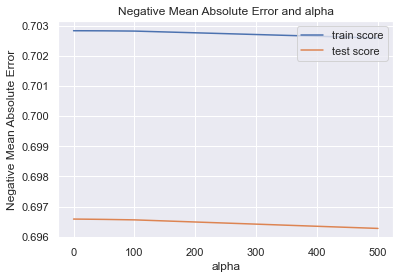

In [61]:
# plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [62]:
# get the best estimator for lambda

ridge_model_cv.best_estimator_

Ridge(alpha=0.0001)

In [63]:
# check the coefficient values with lambda = 10

alpha = 100
ridge = Ridge(alpha=alpha)

ridge.fit(X_train1, y_train)
ridge.coef_

array([-3.62609274, -3.66351204, -6.53019304,  4.34604025,  4.86889322,
       -7.97381859,  4.89440229,  4.69654018, -5.06955457, -4.30603455,
        4.01270365,  4.17986929])

In [64]:
y_hat_train1 = ridge.predict(X_train1)
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:22.734441577548502, R2:0.7023776542763729


In [65]:
# Evaluating on Test Data Set
y_hat_test1 = ridge.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)

test set RMSE:22.910664520456383, R2:0.6960404255371112


In [66]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['Ridge'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,22.734165,0.702385,22.914265,0.695945
1,SVM,21.428641,0.735585,21.828222,0.724084
2,DT,17.511832,0.823412,21.182565,0.740165
3,DF,21.117494,0.743208,20.811150,0.749197
4,DF with Tuning,21.117494,0.743208,20.285306,0.761711
5,Ridge,22.734442,0.702378,22.910665,0.696040


- Perfomance have reduced with Ridge Regression Model. We need to apply Hyper paramter tuning to improve the perfomance.

### Model 6 : XG Boost Algorithm

In [67]:
import xgboost as xg
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
xgb_r.fit(X_train1, y_train)


[10:48:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
# Evaluating on Train Data Set
y_hat_train1 = xgb_r.predict(X_train1)
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:19.642670593349546, R2:0.7778235515573602


In [69]:
# Evaluating on Test Data Set
y_hat_test1 = xgb_r.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)

test set RMSE:19.657038779098624, R2:0.7762429927754897


In [70]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['XgBoost'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,22.734165,0.702385,22.914265,0.695945
1,SVM,21.428641,0.735585,21.828222,0.724084
2,DT,17.511832,0.823412,21.182565,0.740165
3,DF,21.117494,0.743208,20.811150,0.749197
4,DF with Tuning,21.117494,0.743208,20.285306,0.761711
5,Ridge,22.734442,0.702378,22.910665,0.696040
6,XgBoost,19.642671,0.777824,19.657039,0.776243


- With Xgboost model which is favourite for Kaggle competitions and very powerful model , accuracy has increased.We can see that over model is not overfitting as XGboost offers regularized gradient boosting framework.

### Model 6 : Neural Network Model

In [71]:
import tensorflow as tf

In [72]:
ann = tf.keras.models.Sequential()

In [73]:
ann.add(tf.keras.layers.Dense(units=26, activation='relu'))

In [74]:
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))

In [75]:
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))

In [76]:
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [77]:
ann.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [78]:
ann.fit(X_train1, y_train, batch_size = 32, epochs = 75)

Epoch 1/75
645/645 [==============================] - 1s 1ms/step - loss: 3715.3433 - mae: 48.4038
Epoch 2/75
645/645 [==============================] - 1s 1ms/step - loss: 502.1473 - mae: 17.5918
Epoch 3/75
645/645 [==============================] - 1s 1ms/step - loss: 455.1512 - mae: 16.5126
Epoch 4/75
645/645 [==============================] - 1s 1ms/step - loss: 447.6913 - mae: 16.3267
Epoch 5/75
645/645 [==============================] - 1s 2ms/step - loss: 443.2399 - mae: 16.2105
Epoch 6/75
645/645 [==============================] - 1s 1ms/step - loss: 442.5375 - mae: 16.2190
Epoch 7/75
645/645 [==============================] - 1s 1ms/step - loss: 441.2794 - mae: 16.1634
Epoch 8/75
645/645 [==============================] - 1s 1ms/step - loss: 440.6047 - mae: 16.1481
Epoch 9/75
645/645 [==============================] - 1s 1ms/step - loss: 439.1864 - mae: 16.1164
Epoch 10/75
645/645 [==============================] - 1s 1ms/step - loss: 438.0055 - mae: 16.0906
Epoch 11/75
645/64

In [79]:
# Evaluating on Train Data Set
y_hat_train1 = ann.predict(X_train1)
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:20.285783899536895, R2:0.7630369984098447


In [80]:
# Evaluating on Test Data Set
y_hat_test1 = ann.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1,'test')

test set RMSE:20.25795285414517, R2:0.7623534204083686


In [81]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['ANN'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,22.734165,0.702385,22.914265,0.695945
1,SVM,21.428641,0.735585,21.828222,0.724084
2,DT,17.511832,0.823412,21.182565,0.740165
3,DF,21.117494,0.743208,20.811150,0.749197
4,DF with Tuning,21.117494,0.743208,20.285306,0.761711
5,Ridge,22.734442,0.702378,22.910665,0.696040
6,XgBoost,19.642671,0.777824,19.657039,0.776243
7,ANN,20.285784,0.763037,20.257953,0.762353


- With ANN model perfomance is nearby to the XgBoost Model

## Conclusion

1. We have applied different type of ML Models and see how they are performing.
2. Best results we are getting is with XGBoost & ANN Model. But with ANN model we know model is not intutive in nature.
3. Further in my future posts wil try to perform below listed feature engineering to enhance the performamnce of model:
   Creating Categorical variable " Alarm for Low & High Sensor Variable" .
   Creating new features with lagged values.
   Applying feature transformation like mean,SD,etc.
   We can also set new features
   with related to % change in peak value of sensors.
4. Many more feature engineering techniques can be applied subject to having domain knowledge of sensors , Machine past   history , machine OEM reccomendations etc.
